# Ethanol tutorial

In this tutorial, you will learn how to setup a LAMMPS molecular dynamics simulation using the Molecular Simulation Design Framework (MoSDeF).

The MoSDeF is a set of open source tools whose goal is to allow the molecular simulation practitioner to easily setup calculations in different simulation engines. They have been developed by researchers in a University consortium that includes Vanderbilt, Michigan, Notre Dame, among others. The MoSDeF include tools to generate initial configurations (mBuild), force field assignment (foyer), data management and automatic submission to University clusters and supercomputers (signac) and Python interfaces to various simulation engines such as Cassandra (mosdef_cassandra). They have extensions with popular molecular simulation engines such as LAMMPS, GROMACS, Cassandra, GOMC, and others.

# Importing the required modules

In [106]:
import mbuild
import foyer
import numpy as np
import matplotlib.pyplot as plt
import json

# We'll filter out warnings. This is to improve the
# clarity of this tutorial. Please refrain to do this
# if you are not completely sure what these mean.

from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

The first module is the mBuild package. Its goal is to build the initial configuration of a simulation. It has extensions to build bulk liquids, monolayers, polymers, interfaces, porous materials, etcetera. You can take a look at its documentation [here](https://mbuild.mosdef.org/en/stable/index.html). In this tutorial, we will build a bulk system of ethanol.

The second package is foyer. Its goal is to assign the atom types and other parameters (such as bond, angle, dihedral, non-bonded parameters) to a system. It looks at the chemical environment of a system to decide which is the best atom type to assign. Available force fields include OPLS and TraPPE. Look at its documentation [here](https://foyer.mosdef.org/en/stable/).

The third and fourth packages are numpy and matplotlib, core Python packages used for numerical analysis and plotting, respectively.

# Create a single molecule without parameters

Let us create an ethanol molecule using mBuild. We will use the mBuild function `load` which creates a new molecule using [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings. SMILES strings are a popular way of specifying chemical species using text. Alternatively, you can load common chemistry formats such as CIF or PDB.

In [107]:
ethanol_unparametrized = mbuild.load("CCO", smiles=True)
# Name this so that the atom naming works for LAMMPS
ethanol_unparametrized.name = "ETO"
type(ethanol_unparametrized)

mbuild.compound.Compound

The last line displays the type of the variable `ethanol_unparametrized`. It is an `mbuild.compound.Compound` object, which is the way mBuild stores molecules. For example, you can display the coordinates of the atoms as

In [108]:
ethanol_unparametrized.xyz

array([[ 0.09189937, -0.00594586,  0.01217038],
       [-0.05706365, -0.0342368 , -0.00293866],
       [-0.13195045,  0.07921559,  0.03115547],
       [ 0.1144495 ,  0.02423815,  0.11664925],
       [ 0.12245649,  0.07555389, -0.05681231],
       [ 0.15001536, -0.09734961, -0.01227458],
       [-0.08528208, -0.11740867,  0.06501003],
       [-0.07936141, -0.06589767, -0.10735562],
       [-0.12516312,  0.14183097, -0.04560394]])

At this point, our ethanol molecule has no force field parameters assigned to it.

# Fill a simulation box with the ethanol molecule

Using our unparametrized ethanol molecule, we can create a simulation box using mBuild

In [109]:
box = mbuild.Box(3 * [4.0])
type(box)

mbuild.box.Box

This command creates a cubic box whose dimensions are 4 nm each side. The type of the variable `box` is an mBuild box. It contains attributes such as the dimensions and angles between the box edges.

In [110]:
box.lengths, box.angles

((4.0, 4.0, 4.0), (90.0, 90.0, 90.0))

Now let us fill an mBuild box with our ethanol molecules

In [111]:
filled_box = mbuild.fill_box(compound=ethanol_unparametrized, n_compounds=200, box=box)
type(filled_box)

mbuild.compound.Compound

Again, the type of `filled_box` is an `mbuild.compound.Compund`. This mbuild Compound will encompass the box that we defined in the `fill_box` method, as well as our 200 ethanol molecules.

In [112]:
filled_box.box

Box: Lx=4.000000, Ly=4.000000, Lz=4.000000, xy=0.000000, xz=0.000000, yz=0.000000, 

In [113]:
filled_box.n_particles, filled_box.n_bonds

(1800, 1600)

We have 1800 atoms (9 atoms per molecule) and 1600 bonds (8 bonds per molecule).

# Assign force field parameters to the system

We can now use foyer to assign force field parameters. We will use the OPLS force field (optimized potentials for liquid simulations)

In [114]:
ff = foyer.Forcefield(name="oplsaa")
filled_box_parmed = filled_box.to_parmed(infer_residues=True)
filled_box_parmed_parametrized = ff.apply(filled_box_parmed) #parmed.Structure

/home/emarinri/miniconda3/envs/lammps-tutorial/lib/python3.10/site-packages/foyer/validator.py:165: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)


The first line defines foyer force field to contain the set of OPLS force field parameters. 

Then, we convert the box of unparametrized ethanol molecules to a ParmEd structure. ParmEd is a Python package that is not part of the MoSDeF ecosystem. It is used as an auxiliary tool as it provides a flexible data structure that can hold a parametrized systems. This data structure is named a ``parmed.Structure``.

The third line applies the OPLS force field to our box full of unparametrized ethanol molecules. As a result, we will get a ParmEd structure with parametrized ethanol molecules.

# Create a LAMMPS data file

At this point, we have all the information required by a LAMMPS data file. We will use mBuild to generate this

In [115]:
mbuild.formats.lammpsdata.write_lammpsdata(
   filled_box_parmed_parametrized, 
   "ethanol.data",
   atom_style="full",
   unit_style="real",
   use_rb_torsions=True,
)

No urey bradley terms detected, will use angle_style harmonic
RB Torsions detected, will use dihedral_style opls


Let's look at the first few lines of the data file

In [116]:
!head -n 32 ethanol.data

ethanol.data - created by mBuild; units = real

1800 atoms
1600 bonds
2600 angles
2400 dihedrals
0 impropers

5 atom types
5 bond types
7 angle types
4 dihedral types

0.000000 40.000000 xlo xhi
0.000000 40.000000 ylo yhi
0.000000 40.000000 zlo zhi

Masses

1	12.010780	# opls_135
2	1.007947	# opls_140
3	15.999430	# opls_154
4	1.007947	# opls_155
5	12.010780	# opls_157

Pair Coeffs # lj
#	epsilon (kcal/mol)		sigma (Angstrom)
1	0.06600		3.50000		# opls_135
2	0.03000		2.50000		# opls_140
3	0.17000		3.12000		# opls_154
4	0.00000		10.00000		# opls_155
5	0.06600		3.50000		# opls_157


The simulation box has 1800 atoms (200 molecules). The number of bonds, angles and dihedrals seem to be consistent to the number of molecules in the box.

# Run an NPT LAMMPS simulation

Now that we have a LAMMPS data file, we are ready to run a simulation if we have an input file ready. The file `in.mol_npt` is a template you can use to run NPT simulations. This is what it looks like

In [117]:
!cat in.mol_npt

###################################################################
# This is a LAMMPS input file to run an NPT simulation of ethanol.
###################################################################
# User input information
variable        NAME index mol               # The prefix of the log and LAMMPS dump file names
log             ${NAME}.log
variable        infile index ethanol.data    # The name of the LAMMPS input data file
variable        mytemp index 298.00          # The simulation temperature in K
variable        mypress index 1.0            # The simulation pressure (for NpT) in atm

variable        xyzfreq index 1000           # The output frequency of coordinate information
variable        thermofreq index 1000        # The output frequency of property information
variable        simlength index 10000       # Simulation run length  (in timesteps)

variable        restartfreq index 5000       # The output frequency of restart files 

# Properties to output
variable     

We are ready to run the simulation! If you have access to a University cluster, you might want to use the relevant submission scripts. Otherwise, you can run a short simulation locally

In [118]:
!lmp_serial < in.mol_npt

LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (40 40 40)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1800 atoms
  scanning bonds ...
  1 = max bonds/atom
  scanning angles ...
  6 = max angles/atom
  scanning dihedrals ...
  6 = max dihedrals/atom
  reading bonds ...
  1600 bonds
  reading angles ...
  2600 angles
  reading dihedrals ...
  2400 dihedrals
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0.5     
  special bond factors coul:  0        0        0.5     
     4 = max # of 1-2 neighbors
     4 = max # of 1-3 neighbors
     7 = max # of 1-4 neighbors
     8 = max # of special neighbors
  special bonds CPU = 0.001 seconds
  read_data CPU = 0.015 seconds
Ewald initialization ...
  using 12-bit tables for long-range coulomb (src/kspace.cpp:342)
  G vector (1/distance) = 0.17359515
  estimated absolute RMS force accuracy = 0.036289803
  estimated relative force accuracy = 0.00010928566
  KSpace vec

      8000   21617.255      290.23939     -686.32594      1556.4021     -308.92509      1247.477       1031.1022     -520.85852      3586.7872     -1561.9927      502.98741      624.27631      125.80391      0              1253.0676     -4627.9214     -21.373167      27.856947      27.856947      27.856947      0              0              0              0.70775705   
      9000   21036.555      294.65352     -443.56122      1580.0728     -356.8568       1223.216       1087.1329     -526.70296      3572.8138     -1582.1859      475.7126       640.19199      109.42451      0              1225.3291     -4628.2968     -21.963159      27.605241      27.605241      27.605241      0              0              0              0.72729421   
     10000   20390.987      300.42927     -2269.5937      1611.0451     -364.87151      1246.1736      571.23815     -566.64289      3580.9493     -1612.8613      488.62283      633.00198      126.36494      0              1247.9897     -4627.1677     -22.

We can plot the system properties, such as density. Let's load the data output by the MD simulation into numpy arrays. The column order is defined in the LAMMPS input file. Python indexing starts with 0. That means, that the first column is refered as the zeroth column.

In [119]:
data_npt = np.genfromtxt("properties.npt.dat")
timestep = data_npt[:, 0]
density_npt = data_npt[:, 1]

We can create a plot for the NPT densities using the matplotlib library

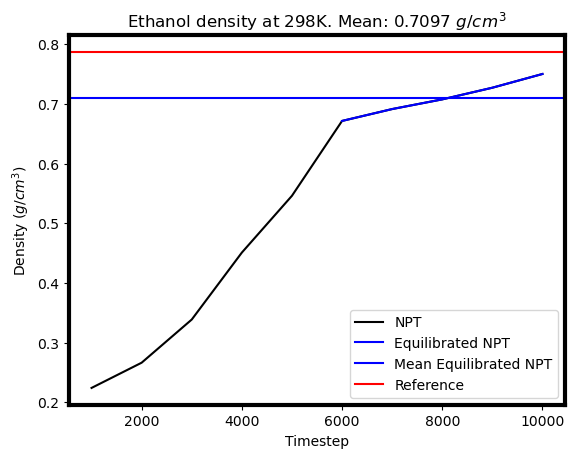

In [120]:
fig, ax = plt.subplots(1, 1)

ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["top"].set_linewidth(3)


half_idx = len(density_npt) // 2
equil_density = density_npt[half_idx:]
equil_timestep = timestep[half_idx:]
mean_density = np.round(np.mean(equil_density), 4)
# The number 0.7873 is taken from the paper shared
# in class
mean_reference = 0.7873

ax.title.set_text(f"Ethanol density at 298K. Mean: {mean_density} $g/cm^3$")
ax.set_xlabel(r"Timestep")
ax.set_ylabel("Density $(g/cm^3)$")
ax.yaxis.tick_left()

ax.plot(timestep, density_npt, "-", color="black", label="NPT")
ax.plot(equil_timestep, equil_density, "-", color="blue", label="Equilibrated NPT")

ax.axhline(y=mean_density, color="b", linestyle="-", label="Mean Equilibrated NPT")
ax.axhline(y=mean_reference, color="r", linestyle="-", label="Reference")

ax.legend(loc="best")
ax.yaxis.set_label_position("left")
plt.show()

The simulation above was run in a laptop, so it was very short. Please look at the `npt.png` image to see how a longer 1 nanosecond simulation looks like.

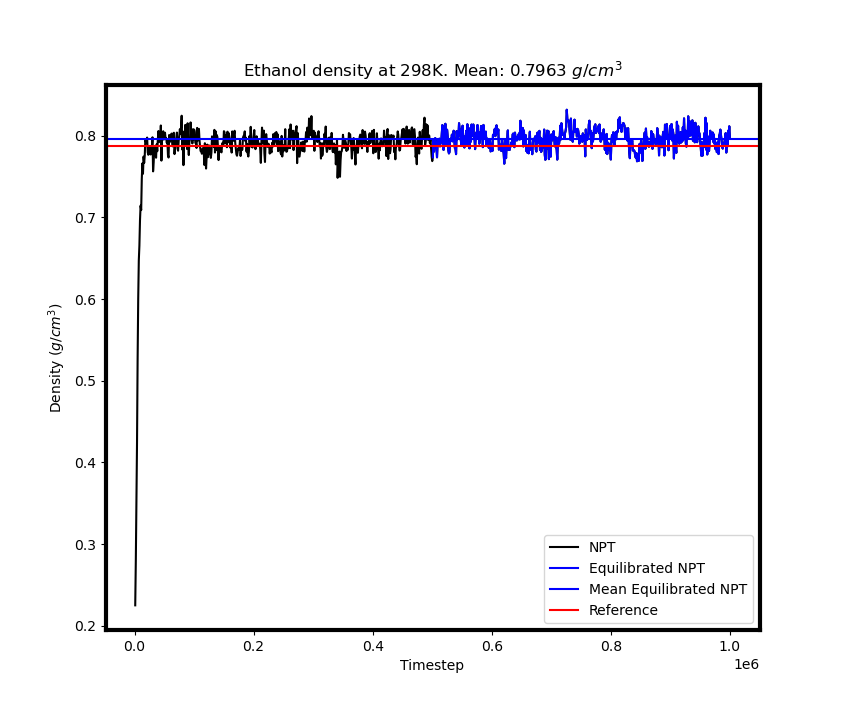

In [121]:
from IPython.display import Image
Image(filename='npt.png') 

The average density and box lengths are

In [122]:
(mean_density, np.mean(data_npt[half_idx:, 8]))

(0.7097, 27.84068)

# Run an NVT LAMMPS simulation

Now we can run an NVT LAMMPS simulation with the results obtained from the previous run. Specifically, we will set the volume box to the average volume box of the equilibrated region of the NPT simulation. You can take a look at the file `restart.npt.reference.data`.

In [123]:
!lmp_serial < in.mol_nvt

LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (26.7852 26.7852 26.7852)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1800 atoms
  reading velocities ...
  1800 velocities
  scanning bonds ...
  1 = max bonds/atom
  scanning angles ...
  6 = max angles/atom
  scanning dihedrals ...
  6 = max dihedrals/atom
  reading bonds ...
  1600 bonds
  reading angles ...
  2600 angles
  reading dihedrals ...
  2400 dihedrals
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0.5     
  special bond factors coul:  0        0        0.5     
     4 = max # of 1-2 neighbors
     4 = max # of 1-3 neighbors
     7 = max # of 1-4 neighbors
     8 = max # of special neighbors
  special bonds CPU = 0.001 seconds
  read_data CPU = 0.027 seconds
Ewald initialization ...
  using 12-bit tables for long-range coulomb (src/kspace.cpp:342)
  G vector (1/distance) = 0.1852368
  estimated absolute RMS force accuracy = 0.033962489
  estim

Let's plot some results from the NVT simulation, such as pressure and potential and kinetic energies.

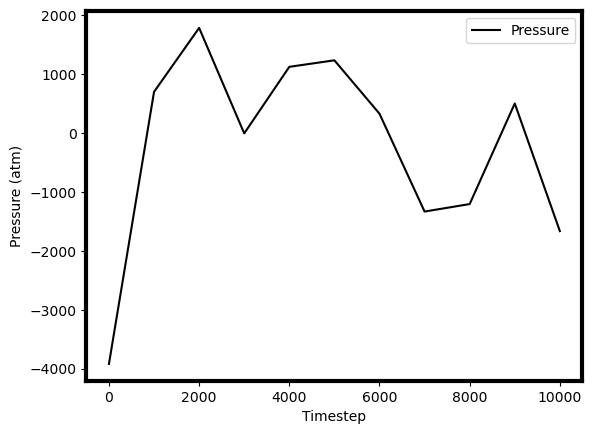

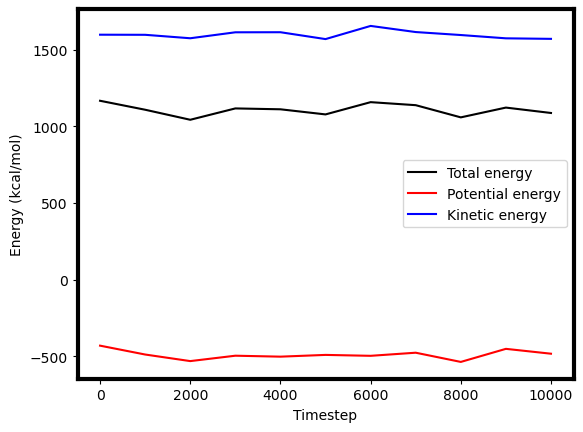

In [124]:
data_nvt = np.genfromtxt("properties.nvt.dat")

timestep = data_nvt[:, 0]
p = data_nvt[:, 3]
toteng = data_nvt[:, 6]
pe = data_nvt[:, 5]
ke = data_nvt[:, 4]

fig, ax = plt.subplots(1, 1)

ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["top"].set_linewidth(3)
ax.set_xlabel("Timestep")
ax.set_ylabel("Pressure (atm)")
ax.yaxis.tick_left()

ax.plot(timestep, p, "-", color="black", label="Pressure")

ax.legend(loc="best")
ax.yaxis.set_label_position("left")

fig2, ax2 = plt.subplots(1, 1)

ax2.spines["bottom"].set_linewidth(3)
ax2.spines["left"].set_linewidth(3)
ax2.spines["right"].set_linewidth(3)
ax2.spines["top"].set_linewidth(3)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Energy (kcal/mol)")
ax2.yaxis.tick_left()

ax2.plot(timestep, toteng, "-", color="black", label="Total energy")
ax2.plot(timestep, pe, "-", color="red", label="Potential energy")
ax2.plot(timestep, ke, "-", color="blue", label="Kinetic energy")

ax2.legend(loc="best")
ax2.yaxis.set_label_position("left")

plt.show()

A longer 1 nanosecond equilibration could look like the following plots

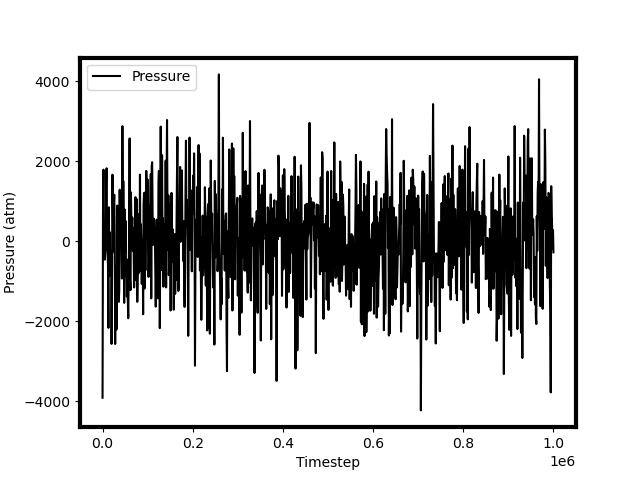

In [125]:
Image(filename='nvt-pressure.png')

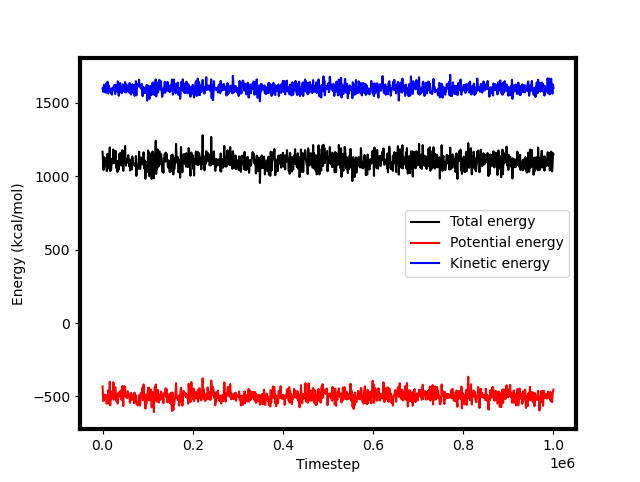

In [126]:
Image(filename='nvt-energy.png')

# Compute RDF and MSD from the NVT trajectory

We can check the liquid structure and dynamics by looking at the radial distribution function (RDF) and mean square displacement (MSD). We can we the PyLAT package to do so.

In [127]:
!pylat -d -g --mol etoh --nummol 200 -p ./ -f etoh.json -v 2 mol.log restart.npt.data mol.nvt.lammpstrj

beginning COM calculation
COM calculation 100.00% complete
beginning RDF calculation
RDF calculation complete
beginning MSD calculation
unwrap complete
MSD calculation 100.00% complete
beginning diffusivity calculation
diffusivity calculation complete
beginning file generation
file generated


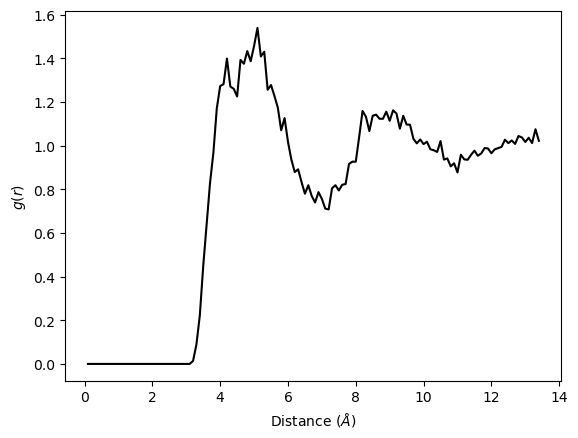

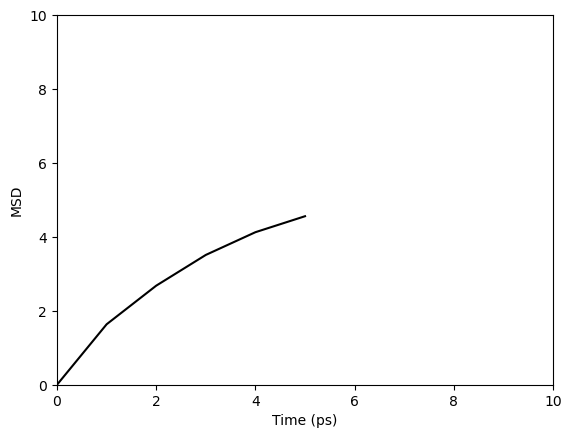

In [128]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel(r"Distance ($\AA$)")
ax.set_ylabel("$g(r)$")

# Open the ethanol.json file (or whatever name
# you gave to it when executing PyLAT)
# and use the json library to parse its
# content

with open("etoh.json", mode="r") as f:
    rdf = json.load(f)

# Plot the RDF
ax.plot(
    rdf["RDF"]["distance"], rdf["RDF"]["etoh-etoh"], "-", color="black", label="RDF"
)

#####################################
# Create a new plot that
# will contain the MSD from PyLAT
#####################################

fig2, ax2 = plt.subplots(1, 1)
ax2.set_xlabel(r"Time (ps)")
ax2.set_ylabel("MSD")

with open("etoh.json", mode="r") as f:
    msd = json.load(f)

# The time in PyLAT is in fs. The x axis of
# Figure 7 of the paper is in ps. We need to
# divide by 1000.0

time = np.array(msd["MSD"]["time"]) / 1000.0

ax2.plot(time, msd["MSD"]["etoh"], "-", color="black", label="MSD")
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])

plt.show()

A longer simulation would yield the following plots

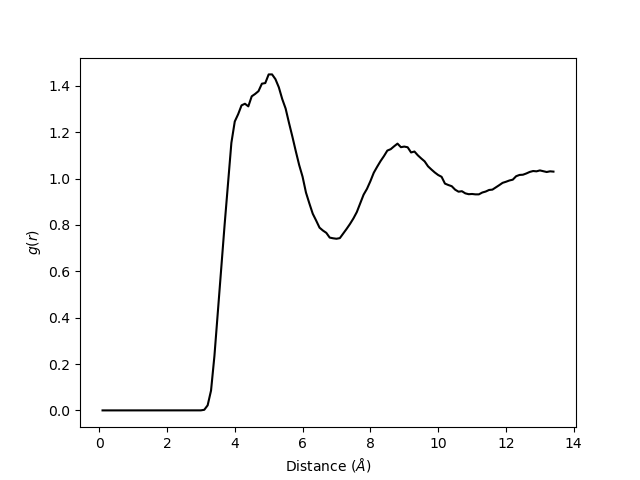

In [129]:
Image(filename="rdf.png")

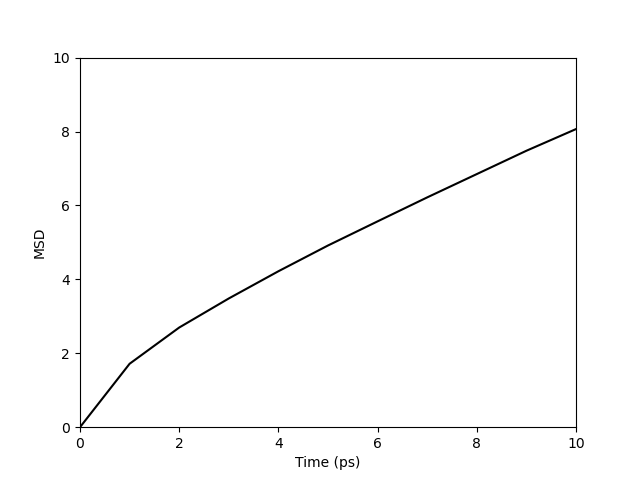

In [130]:
Image(filename="msd.png")

# References

[mBuild documentation](https://mbuild.mosdef.org/en/stable/index.html)

[Foyer documentation](https://foyer.mosdef.org/en/stable/)

[ParmEd documentation](https://parmed.github.io/ParmEd/html/index.html)